In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio
import seaborn as sns

Funções

In [86]:
# Definindo função para computar correlação entre as variáveis e plotar 
def correlation_analysis(df: pd.DataFrame) -> pd.DataFrame:
    
    correlation_matrix = df.corr(numeric_only=True)
    plt.figure(figsize=(16, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
    plt.title("Matriz de Correlação")
    plt.show()
    
    return(correlation_matrix) 



def plot_boxplot(dataframe: pd.DataFrame) -> None:
    ncols = len(dataframe.columns) - 1  # Exclui a coluna "Class"
    nrows = 2
    # Calcular o número de colunas por linha na grade de subplots
    ncols_per_row = ncols // nrows + (ncols % nrows > 0)
    
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols_per_row, figsize=(15, 10), squeeze=False)

    k = 0
    for i in range(nrows):
        for j in range(ncols_per_row):
            if k < ncols:  # Checa se ainda há colunas para plotar
                # A correção crucial: usar ax[i, j] para garantir que um único eixo seja passado
                dataframe.boxplot(column=dataframe.columns[k], by="Class", ax=ax[i, j], grid=True)
                ax[i, j].set_title(dataframe.columns[k])
                ax[i, j].set_ylabel('Reflectance')
                ax[i, j].set_xlabel('Class')
                k += 1
            else:
                ax[i, j].set_visible(False)  # Esconder subplots extras se houver

    plt.tight_layout()
    plt.show()



def plot_histograms(dataframe: pd.DataFrame, class_column: str) -> None:
    # Identificar as classes únicas
    classes = dataframe[class_column].unique()
    
    # Identificar as bandas (colunas), excluindo a coluna de classe
    bands = dataframe.columns.drop(class_column)
    
    # Para cada banda, plotar os histogramas de cada classe
    for band in bands:
        plt.figure(figsize=(12, 8))
        
        for cls in classes:
            # Selecionar os dados da classe atual para a banda atual
            subset = dataframe[dataframe[class_column] == cls][band]
            
            # Plotar o histograma com KDE e transparência para cada classe
            sns.histplot(subset, kde=True, alpha=0.5, label=f'Classe {cls}')
            
        # Adicionar título, rótulos e legenda
        plt.title(f'Histograma de {band} por Classe')
        plt.xlabel(f'Valor de {band}')
        plt.ylabel('Número de Ocorrências')
        plt.legend()
        plt.show()
    



def remove_outliers(df: pd.DataFrame, class_column: str) -> pd.DataFrame:
    df_cleaned = df.copy() #gerando cópia para não prejudicar o df original
    
    # Identificar as classes únicas e dropar do dataframe
    classes = df[class_column].unique()
    features = df.columns.drop(class_column)
    
    # Calculando IQR para cada classe
    for cls in classes:
        for feature in features:
            
            Q1 = df_cleaned[df_cleaned[class_column] == cls][feature].quantile(0.25)
            Q3 = df_cleaned[df_cleaned[class_column] == cls][feature].quantile(0.75)
            IQR = Q3 - Q1
            
            # Limites para determinar outliers
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Filtrando outliers
            condition = (df_cleaned[class_column] == cls) & ((df_cleaned[feature] < lower_bound) | (df_cleaned[feature] > upper_bound))
            df_cleaned = df_cleaned[~condition]
    
    return df_cleaned


def test_normality(df: pd.DataFrame, class_column: str) -> pd.DataFrame:
    classes = df[class_column].unique()
    features = df.columns.drop(class_column)
    
    results_data = []

    for cls in classes:
        for feature in features:
            subset = df[df[class_column] == cls][feature]
            result = anderson(subset)
            
            # O teste de Anderson-Darling retorna um valor e critérios para diferentes níveis de significância
            # Vamos considerar o nível de significância de 5% que é comumente usado
            # result.significance_level é uma lista de níveis de significância testados
            # result.critical_values são os valores críticos correspondentes a esses níveis
            sig_index = list(result.significance_level).index(5.0)
            crit_value = result.critical_values[sig_index]
            is_normal = 'Sim' if result.statistic < crit_value else 'Não'
            
            results_data.append({'Class': cls, 'Feature': feature, 'Statistic': result.statistic, 'Critical value (5%)': crit_value, 'Normal?': is_normal})
    
    # Criar um DataFrame a partir da lista de resultados
    results = pd.DataFrame(results_data)
    
    return results

def test_multivariate_normality(dataframe: pd.DataFrame, class_column: str)-> pd.DataFrame:
    classes = dataframe[class_column].unique()
    features = dataframe.columns.drop(class_column)
    
    results = {}
    for cls in classes:
        # Seleção da classe atual
        subset = dataframe[dataframe[class_column] == cls][features]
        
        # Teste de Henze-Zirkler 
        result = pg.multivariate_normality(subset, alpha=0.05)
        
        # Adicionando resultado num dataframe
        results[cls] = {'Normal': result.normal, 'p-value': result.pval}
        
    return results

Importação de dados e conversão para dataframe

In [2]:
image_path = "G:/Meu Drive/INPE/projeto_dissertacao/imagem_testes_rec.TIF"
samples_path = "G:/Meu Drive/INPE/projeto_dissertacao/amostras.TIF"

In [3]:
with rio.open(image_path) as src:
    image = src.read()
    affine = src.transform  
    profile = src.profile

with rio.open(samples_path) as src2:
    samples = src2.read(1)
    affine2 = src2.transform  
    profile2 = src2.profile

In [4]:
# Conferindo se as imagens tem as mesmas dimensões
if image.shape[1:3] == samples.shape[1:3]:
    print('A imagem e as amostras possuem a mesma quantidade de linhas e colunas')
band_names = ['BLUE','GREEN', 'RED', 'NIR', 'SWIR1','SWIR2']
img_bands, img_rows, img_cols = image.shape
spl_rows, spl_cols = samples.shape

In [6]:
# Escrevendo a imagem como um objeto 2d
I = pd.DataFrame(image.reshape(img_bands,img_rows*img_cols).T)
I.columns = band_names
I

,BLUE,GREEN,RED,NIR,SWIR1,SWIR2
0,7775.0,8086.0,7823.0,7637.0,7305.0,7349.0
1,7776.0,8244.0,7823.0,7481.0,7409.0,7201.0
2,7776.0,8559.0,7823.0,7638.0,7305.0,7350.0
3,8008.0,8559.0,7824.0,7793.0,7305.0,7053.0
4,8163.0,8401.0,7951.0,7793.0,7305.0,7498.0
...,...,...,...,...,...,...
1236031,7690.0,8646.0,7905.0,17863.0,12571.0,8975.0
1236032,7915.0,8799.0,8277.0,19817.0,13495.0,9857.0
1236033,8214.0,9259.0,8649.0,21167.0,14420.0,10004.0
1236034,8214.0,8952.0,8649.0,20868.0,13701.0,9710.0


In [12]:
# Extraindo as posições das amostras / X -> Espaço de Atributos, y -> classe
#Selecionando a posição da amostras no espaço da imagem
sample_selection = image[:,samples>0]
y = pd.DataFrame(samples[samples>0])
y.columns = ['Class']

n_bands, n_pixels = sample_selection.shape
X = pd.DataFrame(sample_selection.reshape(n_bands, n_pixels).T)
X.columns = band_names
X

,BLUE,GREEN,RED,NIR,SWIR1,SWIR2
0,8090.0,8298.0,7993.0,16695.0,12170.0,9273.0
1,8014.0,8298.0,8117.0,16997.0,12479.0,9125.0
2,8014.0,8453.0,7993.0,17908.0,12583.0,9419.0
3,8014.0,8453.0,8117.0,17605.0,12686.0,9419.0
4,7939.0,8609.0,8117.0,17301.0,12788.0,9419.0
...,...,...,...,...,...,...
38545,7788.0,8506.0,8038.0,16831.0,11862.0,8833.0
38546,7863.0,8506.0,8163.0,17586.0,12069.0,8833.0
38547,7938.0,8506.0,8287.0,17284.0,12275.0,8980.0
38548,7938.0,8505.0,8287.0,17584.0,12273.0,9274.0


In [13]:
df_samples = pd.concat([X,y], axis = 1)
df_samples

,BLUE,GREEN,RED,NIR,SWIR1,SWIR2,Class
0,8090.0,8298.0,7993.0,16695.0,12170.0,9273.0,2.0
1,8014.0,8298.0,8117.0,16997.0,12479.0,9125.0,2.0
2,8014.0,8453.0,7993.0,17908.0,12583.0,9419.0,2.0
3,8014.0,8453.0,8117.0,17605.0,12686.0,9419.0,2.0
4,7939.0,8609.0,8117.0,17301.0,12788.0,9419.0,2.0
...,...,...,...,...,...,...,...
38545,7788.0,8506.0,8038.0,16831.0,11862.0,8833.0,2.0
38546,7863.0,8506.0,8163.0,17586.0,12069.0,8833.0,2.0
38547,7938.0,8506.0,8287.0,17284.0,12275.0,8980.0,2.0
38548,7938.0,8505.0,8287.0,17584.0,12273.0,9274.0,2.0


Tratamento do dados e análise exploratória

In [15]:
df_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38550 entries, 0 to 38549
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BLUE    38550 non-null  float32
 1   GREEN   38550 non-null  float32
 2   RED     38550 non-null  float32
 3   NIR     38550 non-null  float32
 4   SWIR1   38550 non-null  float32
 5   SWIR2   38550 non-null  float32
 6   Class   38550 non-null  float32
dtypes: float32(7)
memory usage: 1.0 MB


In [16]:
# Transformação do tipo do dado
df_samples = df_samples.astype({'BLUE': 'int16', 
                                'GREEN': 'int16',
                                'RED':'int16',
                                'NIR':'int16',
                                'SWIR1':'int16',
                                'SWIR2':'int16',
                                'Class':'category'})

In [19]:
print(df_samples.info())
df_samples

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38550 entries, 0 to 38549
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   BLUE    38550 non-null  int16   
 1   GREEN   38550 non-null  int16   
 2   RED     38550 non-null  int16   
 3   NIR     38550 non-null  int16   
 4   SWIR1   38550 non-null  int16   
 5   SWIR2   38550 non-null  int16   
 6   Class   38550 non-null  category
dtypes: category(1), int16(6)
memory usage: 489.7 KB
None


,BLUE,GREEN,RED,NIR,SWIR1,SWIR2,Class
0,8090,8298,7993,16695,12170,9273,2.0
1,8014,8298,8117,16997,12479,9125,2.0
2,8014,8453,7993,17908,12583,9419,2.0
3,8014,8453,8117,17605,12686,9419,2.0
4,7939,8609,8117,17301,12788,9419,2.0
...,...,...,...,...,...,...,...
38545,7788,8506,8038,16831,11862,8833,2.0
38546,7863,8506,8163,17586,12069,8833,2.0
38547,7938,8506,8287,17284,12275,8980,2.0
38548,7938,8505,8287,17584,12273,9274,2.0


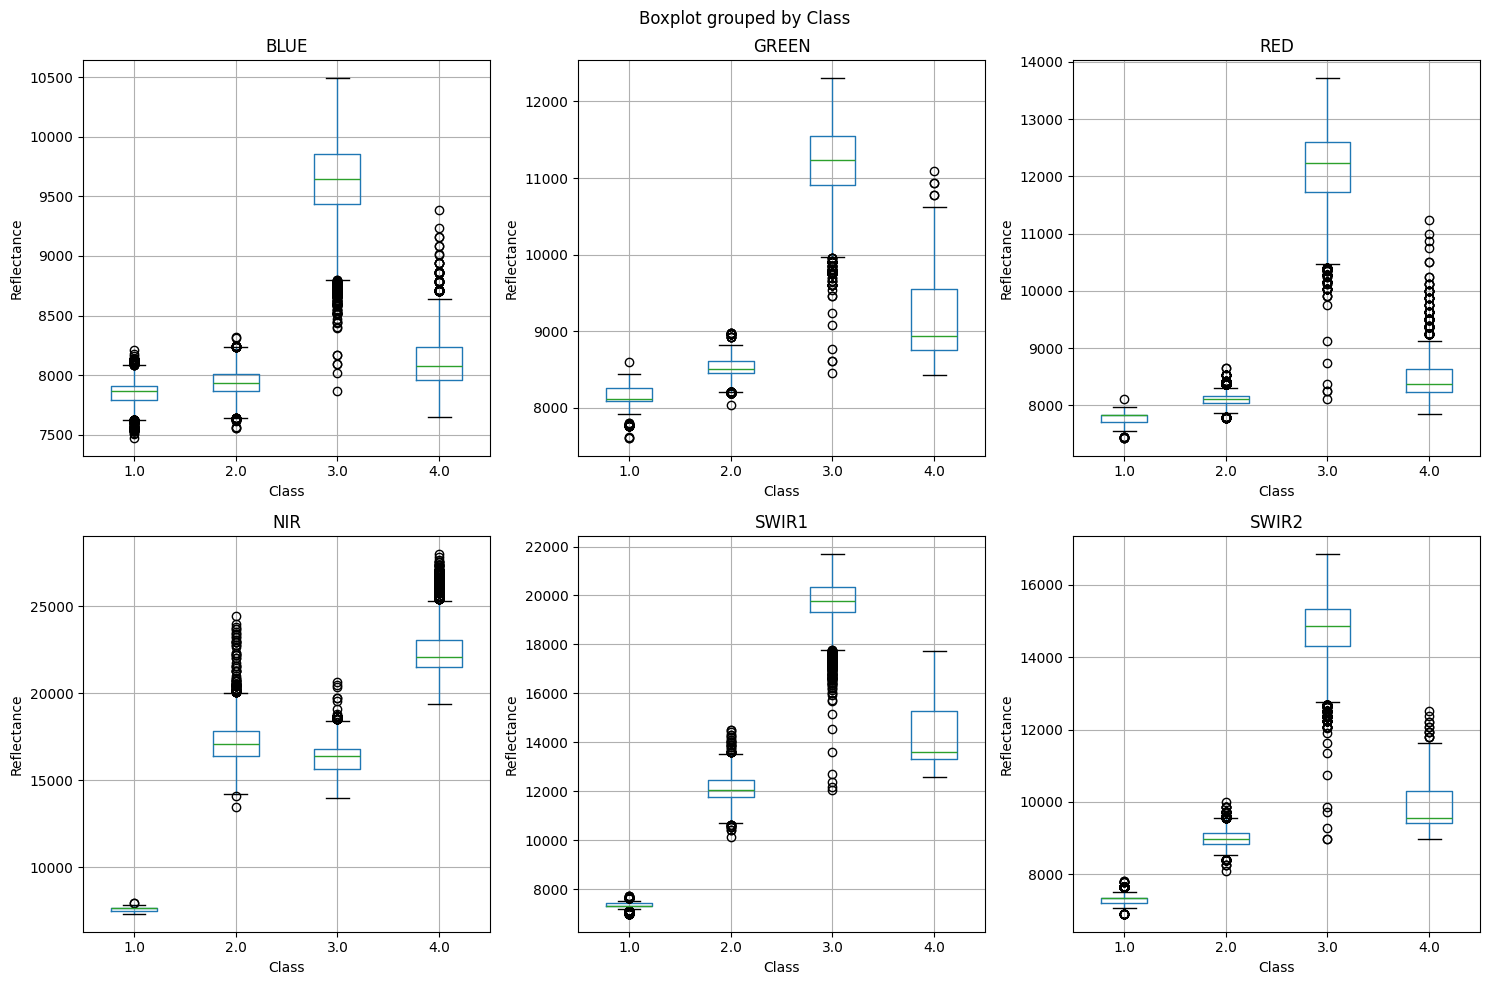

In [55]:
plot_boxplot(df_samples)

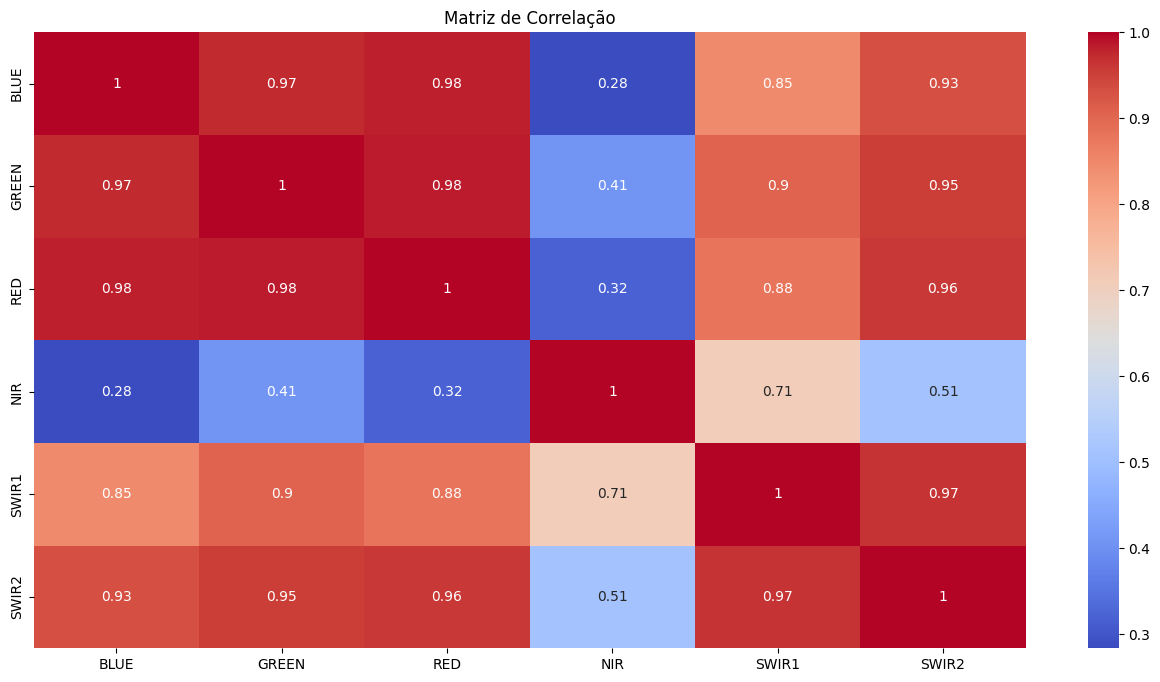

,BLUE,GREEN,RED,NIR,SWIR1,SWIR2
BLUE,1.000000,0.974647,0.980954,0.283363,0.848431,0.931204
GREEN,0.974647,1.000000,0.983645,0.409231,0.904943,0.954468
RED,0.980954,0.983645,1.000000,0.317368,0.881601,0.959314
NIR,0.283363,0.409231,0.317368,1.000000,0.707806,0.508382
SWIR1,0.848431,0.904943,0.881601,0.707806,1.000000,0.965429
SWIR2,0.931204,0.954468,0.959314,0.508382,0.965429,1.000000


In [58]:
correlation_analysis(df_samples)

In [85]:
df_samples_cleaned = remove_outliers(df_samples, 'Class')
df_samples_cleaned.shape

(35110, 7)

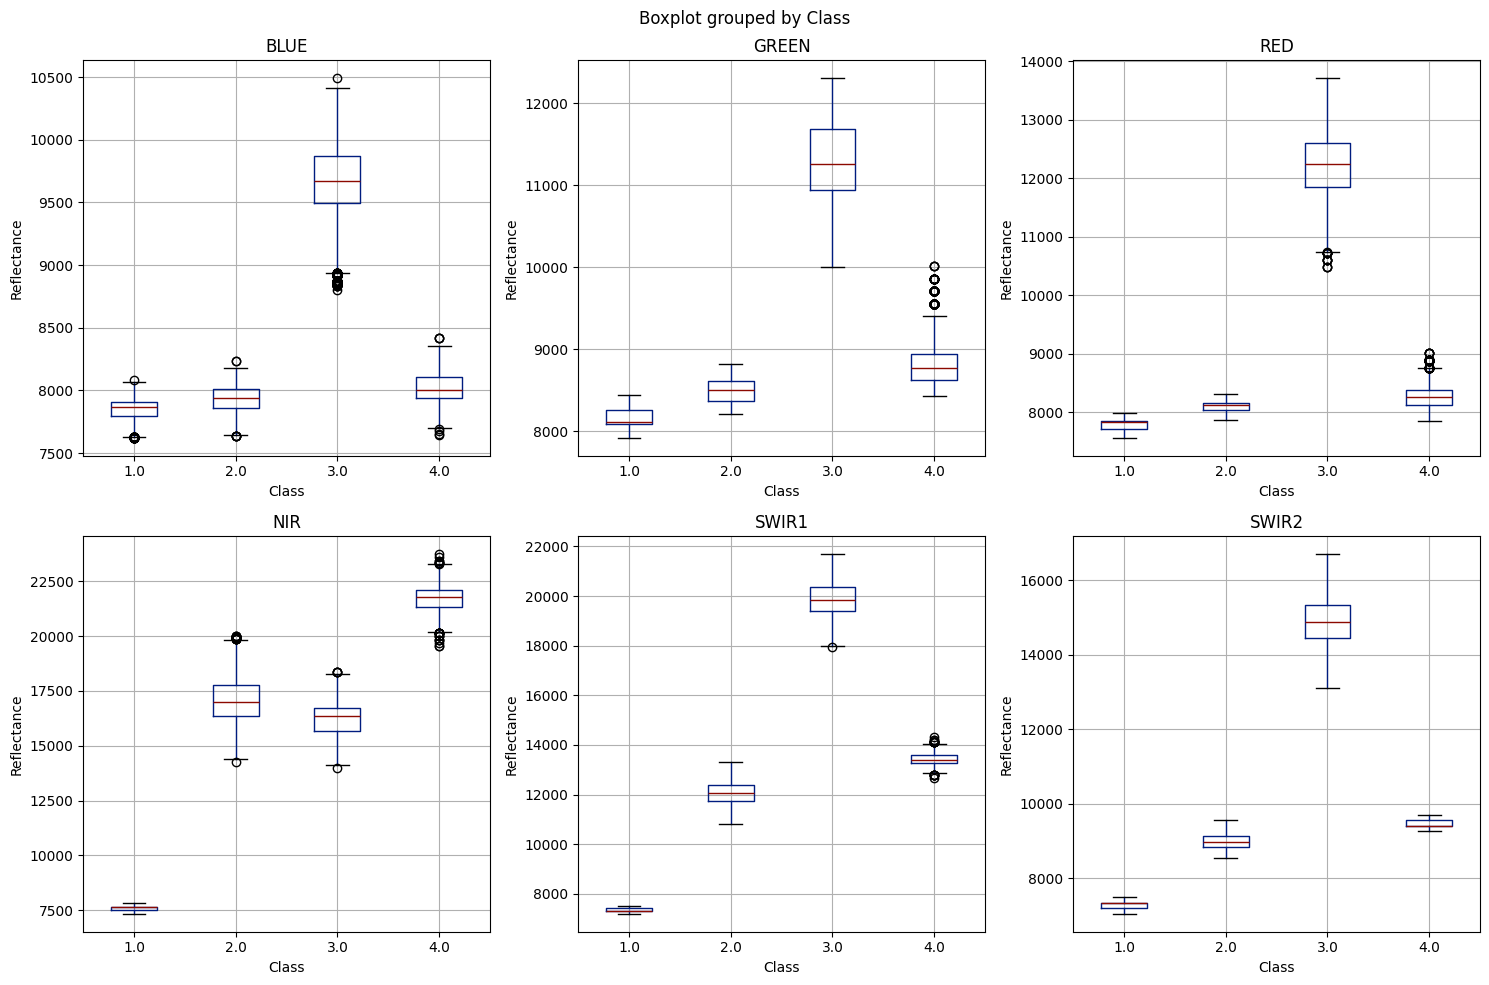

In [87]:
plot_boxplot(df_samples_cleaned)

In [ ]:
# def indexes(image:np.ndarray, sensor:str):